In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from datetime import datetime

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

In [2]:
df = pd.read_csv('marketing_campaign.csv', sep='\t')
df.head(5)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [4]:
df["Age"] = datetime.now().year - df["Year_Birth"]
df["Children"] = df["Kidhome"] + df["Teenhome"]

In [5]:
## droping some columns, merging 'Kidhome' and 'Teenhome' columns
columns_to_remove = ['Recency', 'Z_Revenue', 'Z_CostContact', 'Response', 'Kidhome', 'Teenhome', 'Year_Birth', 'Dt_Customer',
                    'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Complain']
df.drop(columns_to_remove, axis=1, inplace=True)
df.dropna(axis=0, inplace=True)

In [6]:
def detect_outliers(col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - (1.5 * IQR)
    upper_limit = Q3 + (1.5 * IQR)
    outliers = df[(df[col] < lower_limit) | (df[col] > upper_limit)]
    return outliers

In [7]:
outliers = detect_outliers('Income')
df.drop(outliers.index.tolist(), axis=0, inplace=True)

In [8]:
def draw_bar(col_name):
    types = df[col_name].value_counts()
    plt.bar(x=types.index, height=types.values)
    plt.xlabel(col_name)
    plt.ylabel('Count')
    plt.title('Barplot of ' + col_name)
    plt.show()

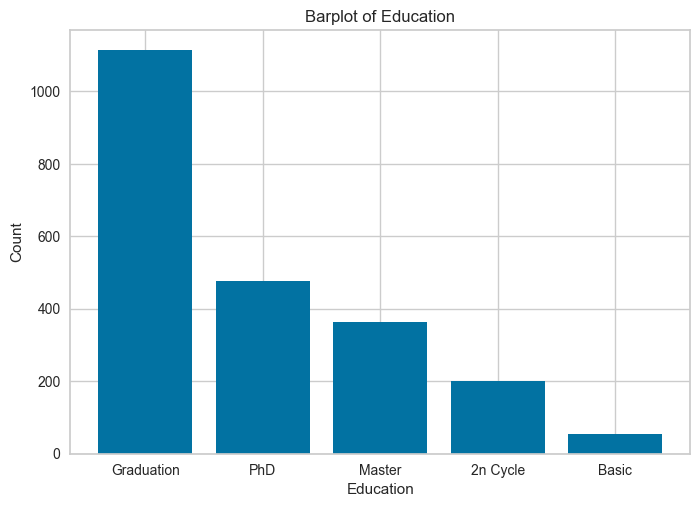

In [9]:
draw_bar('Education')

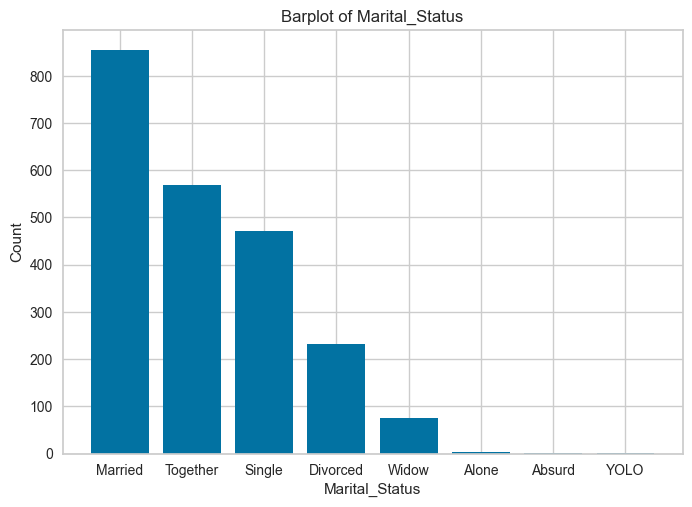

In [10]:
draw_bar('Marital_Status')

In [11]:
indeces = df[(df['Marital_Status'] == 'Absurd') | (df['Marital_Status'] == 'YOLO')].index
df['Marital_Status'] = df['Marital_Status'].replace('Alone', 'Single')
df.drop(indeces, inplace=True)

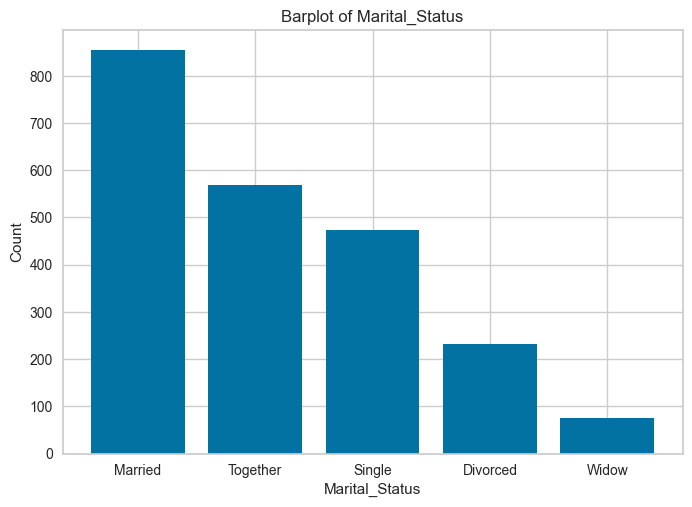

In [12]:
draw_bar("Marital_Status")

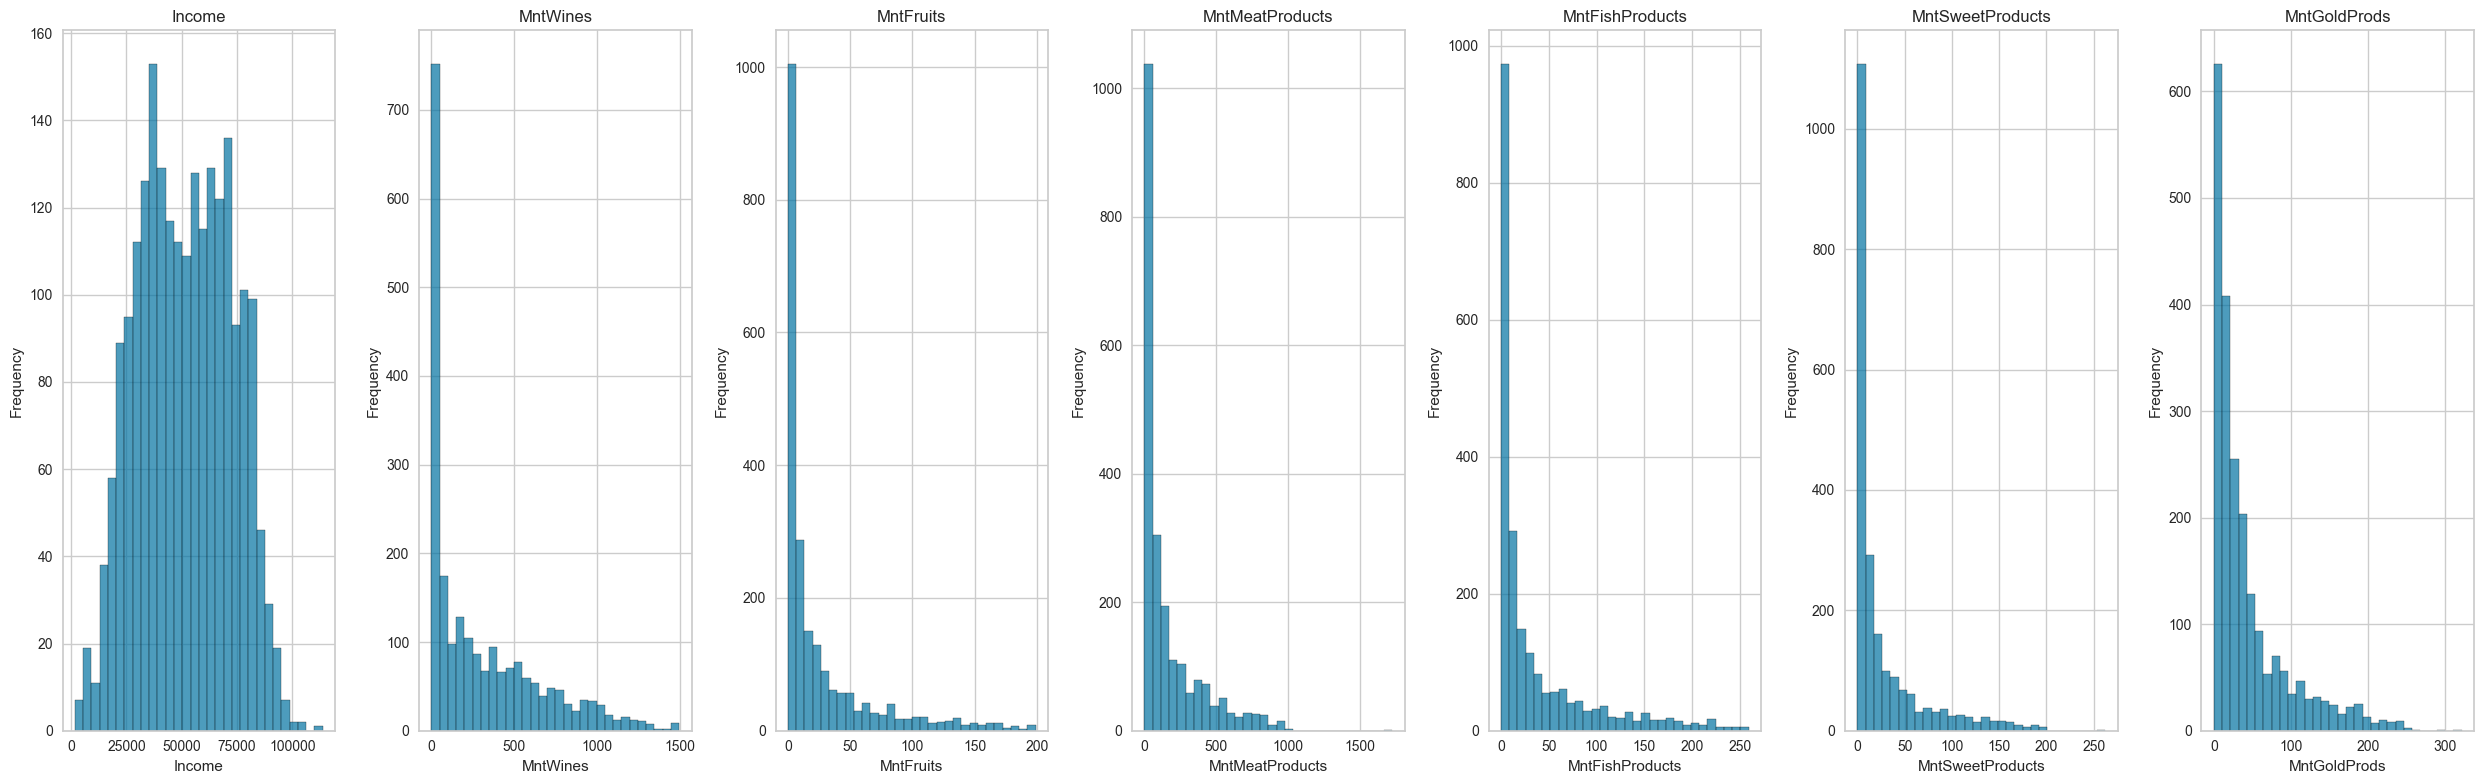

In [15]:
columns_for_interest = ['Income', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
fig, axes = plt.subplots(1, len(columns_for_interest), figsize=(25, 8))

for i, column in enumerate(columns_for_interest):
    axes[i].hist(df[column], bins=30, edgecolor='black', alpha=0.7)
    axes[i].set_title(column)
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')
    
plt.tight_layout()
plt.show()

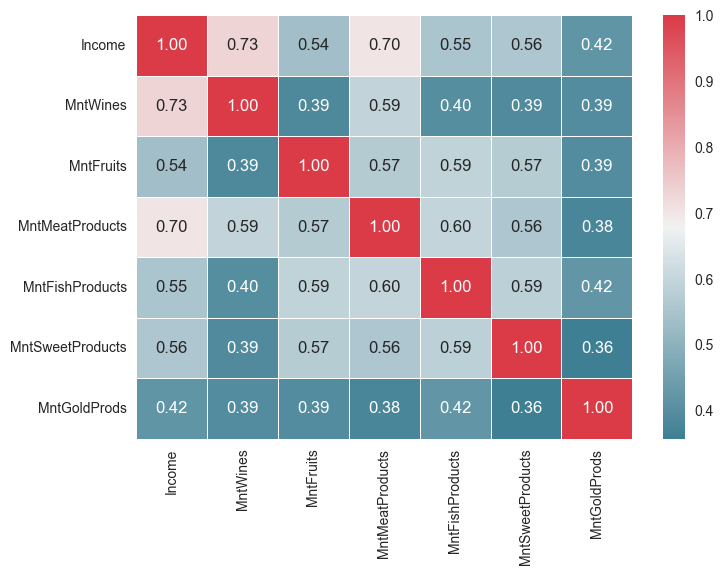

In [16]:
corr = df[columns_for_interest].corr()

sns.heatmap(corr, cmap=sns.diverging_palette(220, 10, as_cmap=True), annot=True, fmt=".2f", linewidths=0.5)

plt.show()

In [17]:
product_columns = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']

def barplot_grouped_data(grouped_data, xlabel, ylabel, title, cmap=None, rotate=True):
    grouped_data.plot(kind='bar', figsize=(10, 6), cmap=cmap)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(rotation=45 if rotate else 0)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [18]:
customer_with_children = df[df['Children'] > 0]
customer_without_children = df[df['Children'] == 0]

In [19]:
spending_with_children = customer_with_children[product_columns].mean()
spending_without_children = customer_without_children[product_columns].mean()

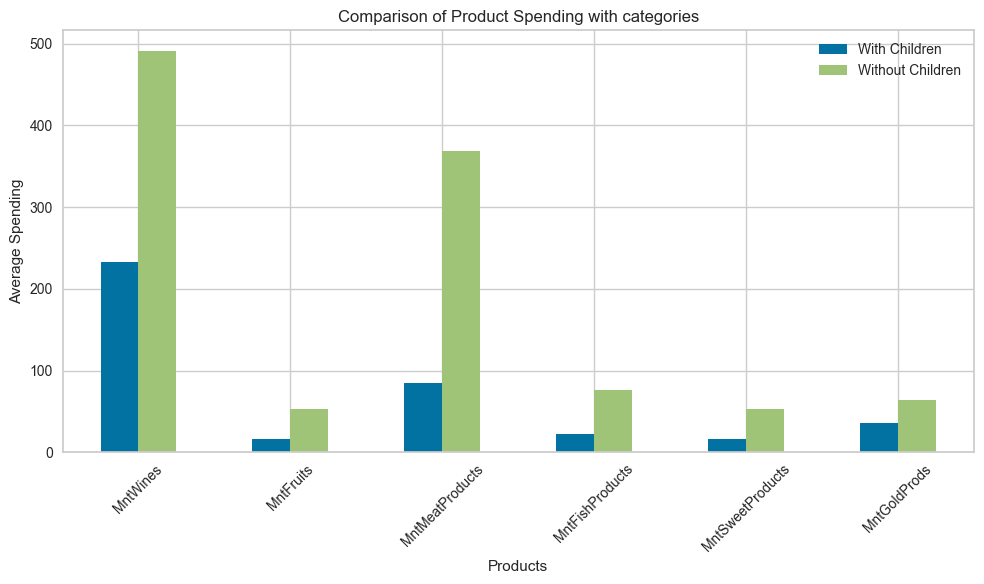

In [20]:
grouped_data = pd.DataFrame({
    'With Children': spending_with_children,
    'Without Children': spending_without_children
}, index=product_columns)
barplot_grouped_data(grouped_data, xlabel='Products', ylabel='Average Spending', title='Comparison of Product Spending with categories')

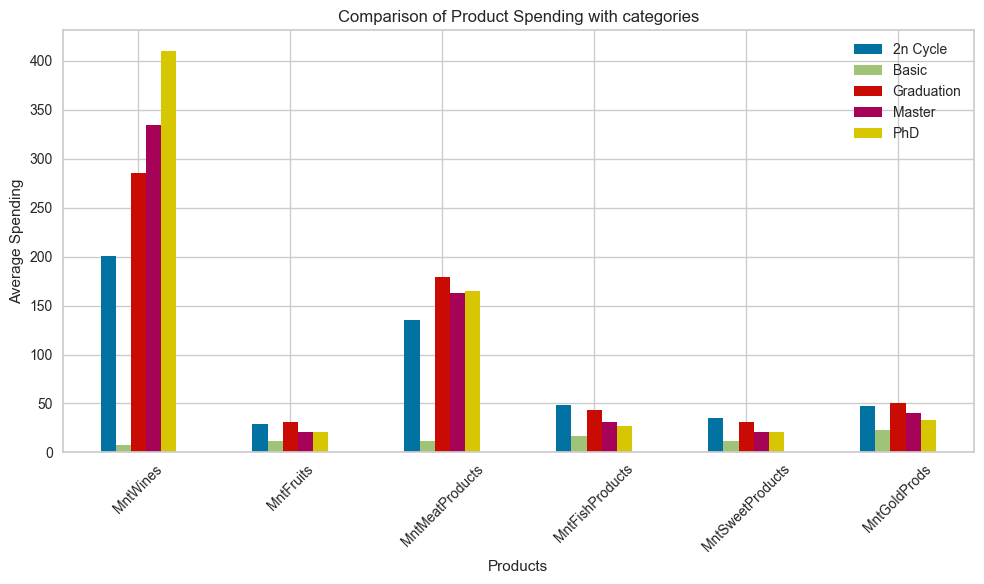

In [21]:
grouped_with_education = df.groupby('Education')[product_columns].mean()
barplot_grouped_data(grouped_with_education.T, xlabel='Products', ylabel='Average Spending', title='Comparison of Product Spending with categories')

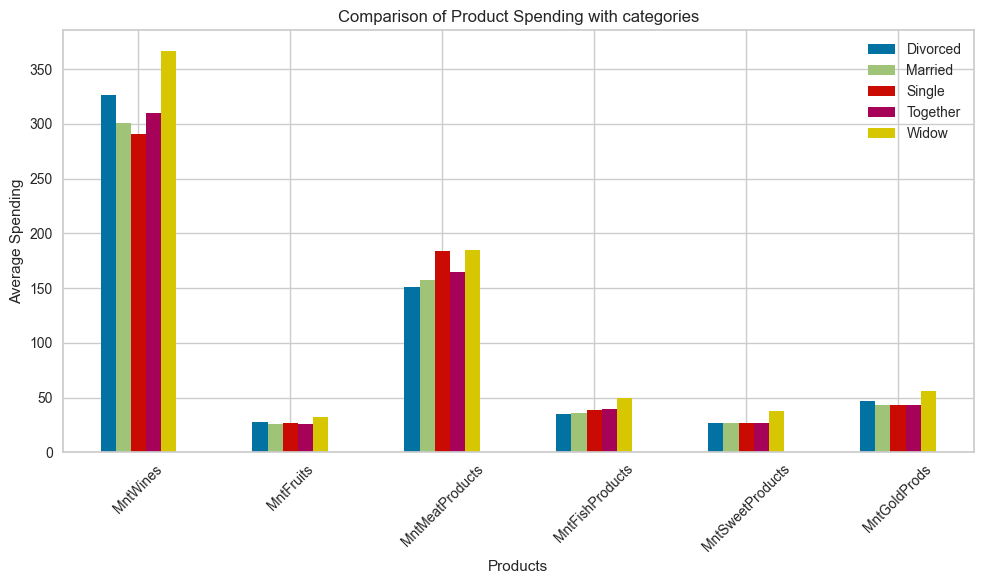

In [22]:
grouped_with_marital = df.groupby('Marital_Status')[product_columns].mean()
barplot_grouped_data(grouped_with_marital.T, xlabel='Products', ylabel='Average Spending', title='Comparison of Product Spending with categories')

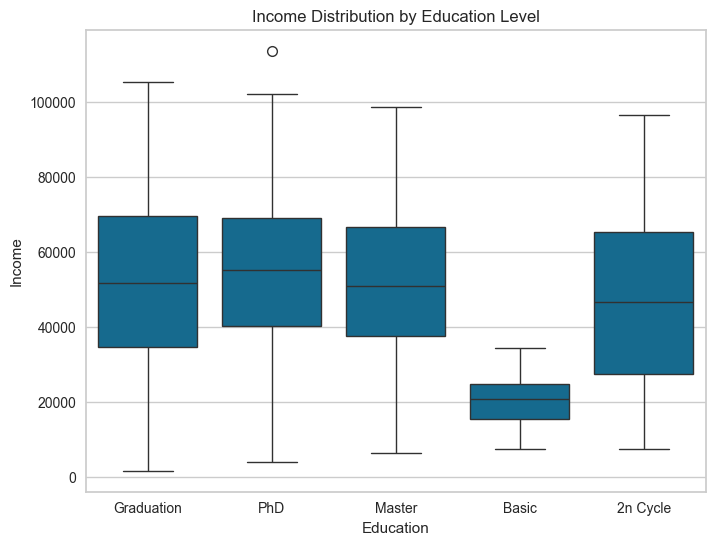

In [23]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Education', y='Income', data=df)
plt.title('Income Distribution by Education Level')
plt.show()

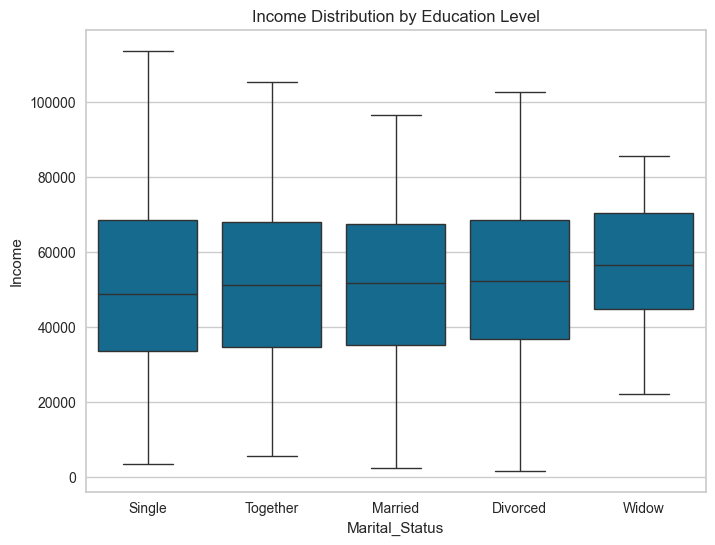

In [24]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Marital_Status', y='Income', data=df)
plt.title('Income Distribution by Education Level')
plt.show()

# Dimensionality Reduction

### PCA

In [25]:
categorical_columns = ['Marital_Status', 'Education']
label_encoder = LabelEncoder()
df_copy = df.copy()
for col in categorical_columns:
    df_copy[col] = df_copy[[col]].apply(label_encoder.fit_transform)

In [26]:
scaler = StandardScaler()
scaler.fit(df_copy)
scaled_ds = pd.DataFrame(scaler.transform(df_copy),columns= df_copy.columns)

In [27]:
n_components = 10
pca = PCA(n_components=n_components)
pca.fit(scaled_ds)

PCA(n_components=10)

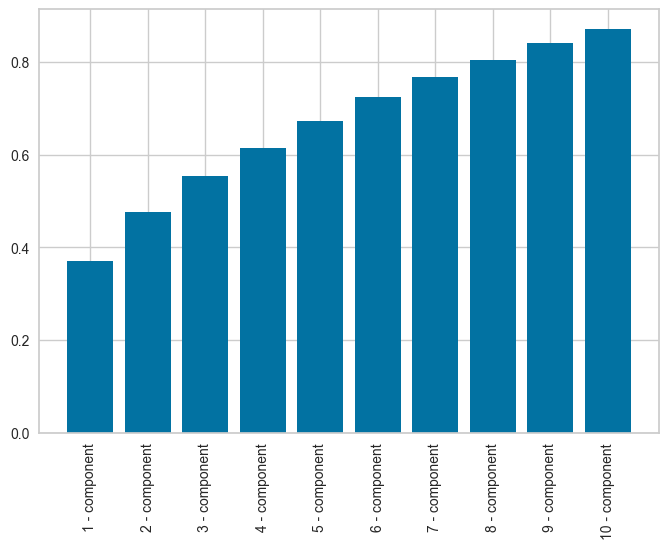

In [28]:
plt.bar([f'{i+1} - component' for i in range(n_components)], np.cumsum(pca.explained_variance_ratio_))
plt.xticks(rotation=90)
plt.show()

In [29]:
pca = PCA(n_components=3)
pca.fit(scaled_ds)

pca_df = pd.DataFrame(pca.transform(scaled_ds), columns=(["col1","col2", "col3"]))
pca_df.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,2204.0,-1.611939e-17,2.510044,-5.455618,-2.277938,-0.710740,2.174865,6.801601
col2,2204.0,3.223878e-17,1.347637,-2.900641,-1.010359,-0.207779,0.827013,5.329160
col3,2204.0,3.868654e-17,1.147920,-3.601637,-0.790379,0.008248,0.738552,5.177884


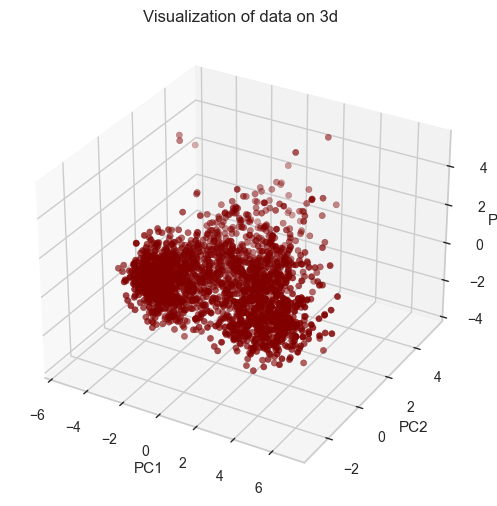

In [30]:
x_pca = pca_df["col1"]
y_pca = pca_df["col2"]
z_pca = pca_df["col3"]

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    xs=x_pca,
    ys=y_pca,
    zs=z_pca,
    c="maroon",
    marker="o",
)
ax.set(
    xlabel="PC1",
    ylabel="PC2",
    zlabel="PC3",
    title="Visualization of data on 3d",
)
plt.show()

### t-SNE

In [31]:
tsne = TSNE(perplexity=30, random_state=42)
z = tsne.fit_transform(df_copy) 

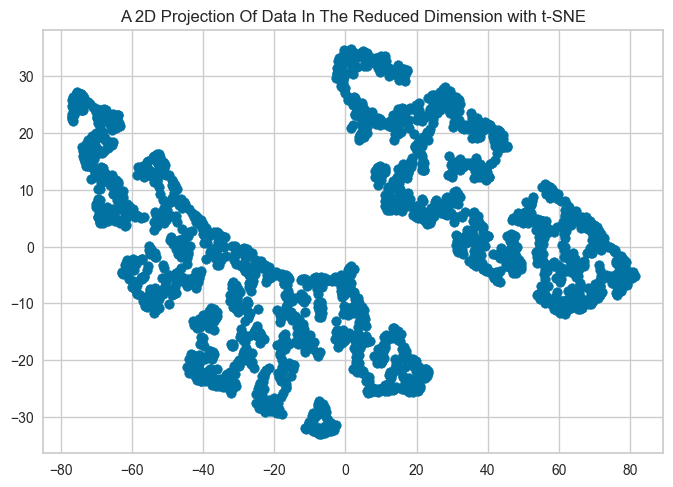

In [32]:
x = z[:,0]
y = z[:,1]
plt.scatter(x, y, marker="o" )
plt.title("A 2D Projection Of Data In The Reduced Dimension with t-SNE")
plt.show()

# Clustering

### K-Means

Doing K-Means on PCA data

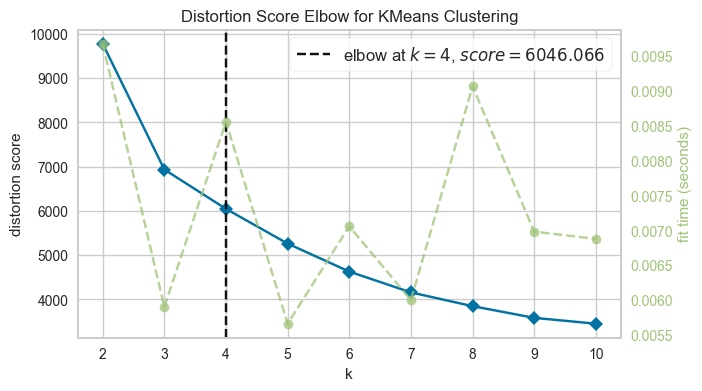

In [33]:
fig, ax = plt.subplots(figsize=(7, 4))
Elbow_M = KElbowVisualizer(KMeans(random_state=42), k=10, ax=ax)
Elbow_M.fit(pca_df)
Elbow_M.show()
plt.show()

In [34]:
kmeans = KMeans(n_clusters=Elbow_M.elbow_value_, random_state=42, init = 'k-means++')
yhat = kmeans.fit_predict(pca_df)
df["Clusters"] = yhat

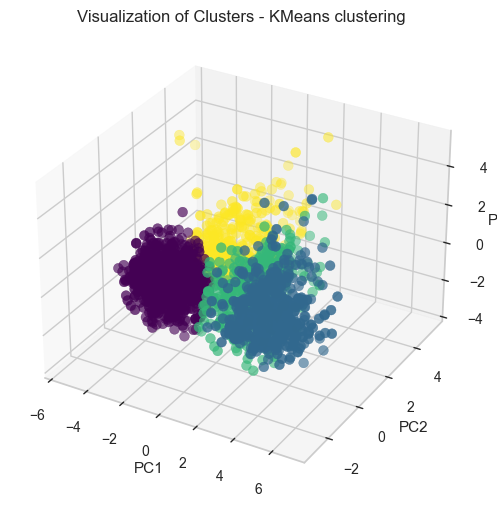

In [35]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    xs=x_pca,
    ys=y_pca,
    zs=z_pca,
    marker="o",
    c=df["Clusters"],
    s=50,
    cmap="viridis",
)
ax.set(
    xlabel="PC1",
    ylabel="PC2",
    zlabel="PC3",
    title="Visualization of Clusters - KMeans clustering",
)
plt.show()

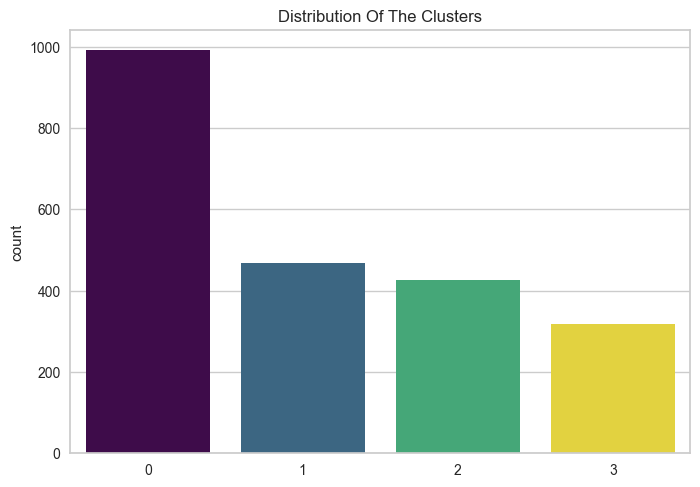

In [36]:
pl = sns.countplot(x=yhat, palette='viridis', hue=yhat, legend=False)
pl.set_title("Distribution Of The Clusters")
plt.show()

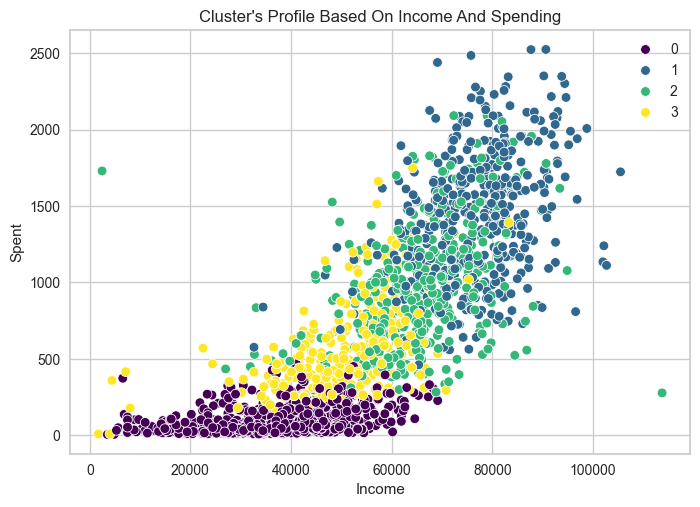

In [37]:
spent = df["MntWines"] + df["MntFruits"] + df["MntMeatProducts"] + df["MntFishProducts"] + df["MntSweetProducts"] + df["MntGoldProds"]
pl = sns.scatterplot(x=df["Income"], y=spent, hue=df["Clusters"], palette='viridis')
pl.set_title("Cluster's Profile Based On Income And Spending")
pl.set_xlabel('Income')
pl.set_ylabel('Spent')
plt.legend()
plt.show()

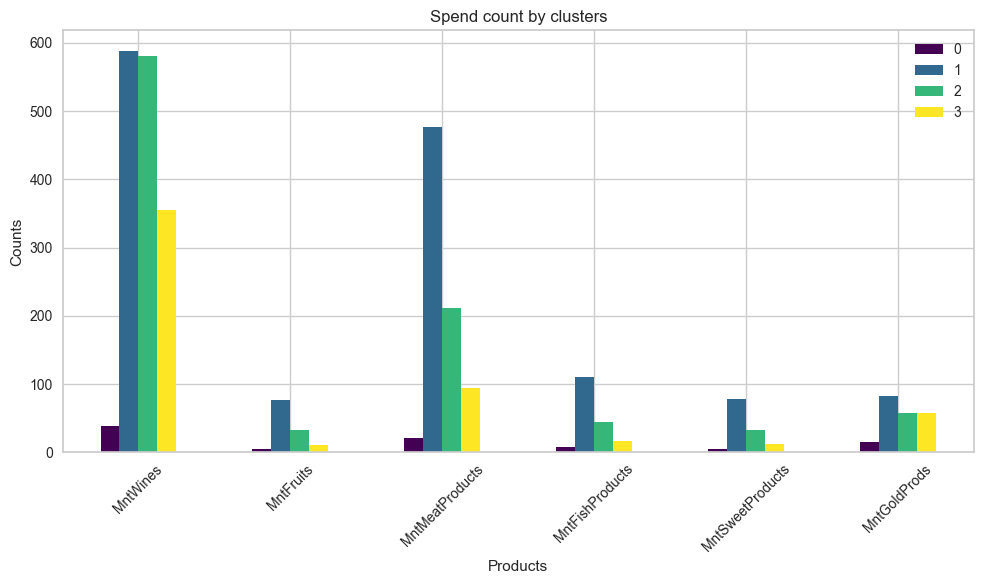

In [38]:
grouped_data = df.groupby('Clusters')[product_columns].mean()
barplot_grouped_data(grouped_data.T, xlabel='Products', ylabel='Counts', cmap='viridis', title="Spend count by clusters")

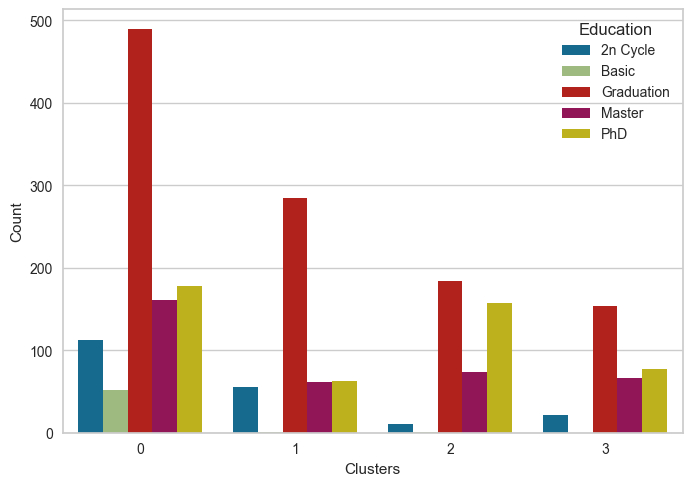

In [39]:
grouped_education_and_cluster = df.groupby(['Education', 'Clusters']).size().reset_index(name='Count')
sns.barplot(x='Clusters', y='Count', hue='Education', data=grouped_education_and_cluster)
plt.show()

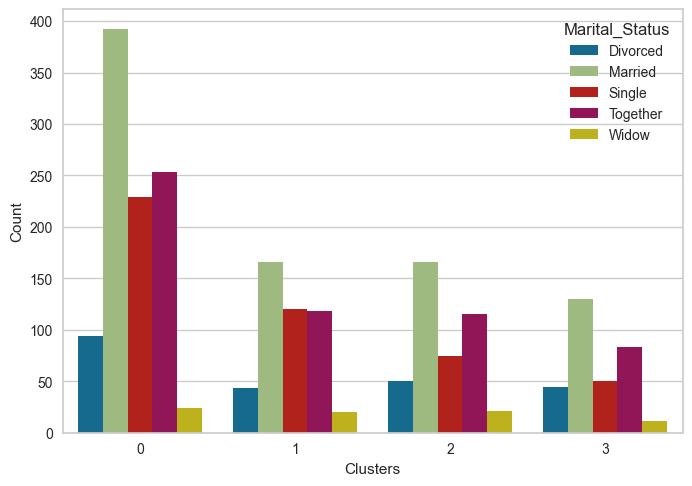

In [40]:
grouped_marital_status_and_cluster = df.groupby(['Marital_Status', 'Clusters']).size().reset_index(name='Count')
sns.barplot(x='Clusters', y='Count', hue='Marital_Status', data=grouped_marital_status_and_cluster)
plt.show()

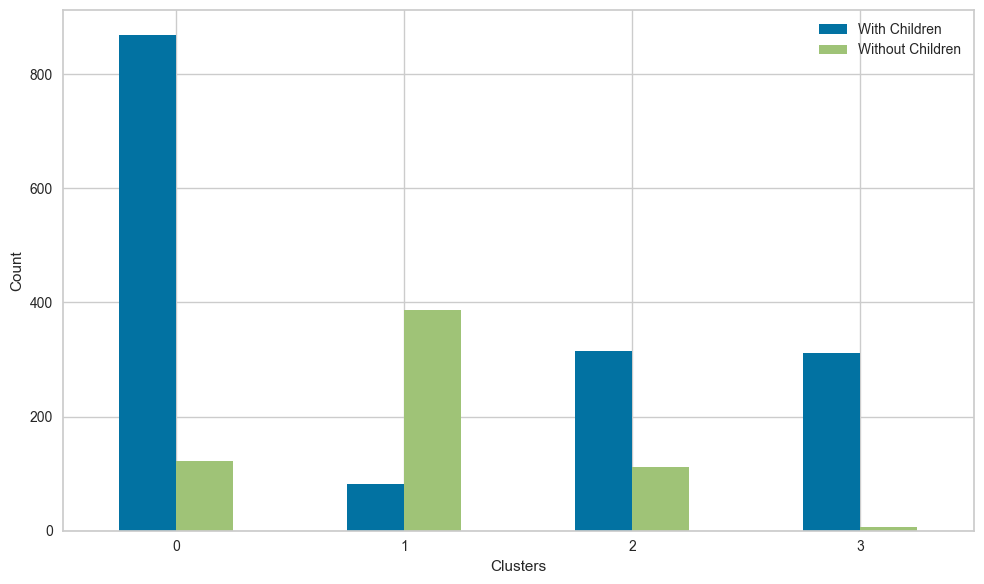

In [41]:
customer_with_children = df[df['Children'] > 0]
customer_without_children = df[df['Children'] == 0]
clusters_with_children = customer_with_children.groupby('Clusters').size()
clusters_without_children = customer_without_children.groupby('Clusters').size()
grouped_data = pd.DataFrame({
    'With Children': clusters_with_children,
    'Without Children': clusters_without_children
})
barplot_grouped_data(grouped_data, xlabel='Clusters', ylabel='Count', title=None, rotate=False)

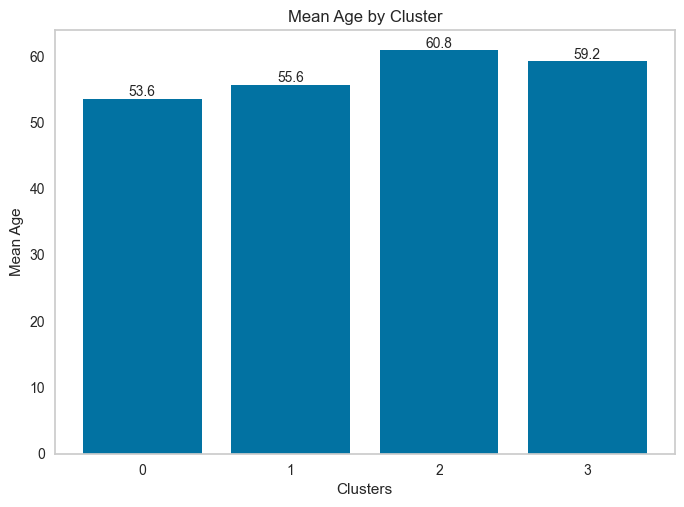

In [42]:
mean_ages = df.groupby('Clusters')['Age'].mean()
plt.bar(mean_ages.index, mean_ages.values)
plt.xlabel('Clusters')
plt.ylabel('Mean Age')
plt.title('Mean Age by Cluster')
plt.xticks(ticks=mean_ages.index, labels=mean_ages.index)
for index, value in enumerate(mean_ages.values):
    plt.text(index, value, f'{value:.1f}', ha='center', va='bottom', fontsize=10)
plt.grid()
plt.show()

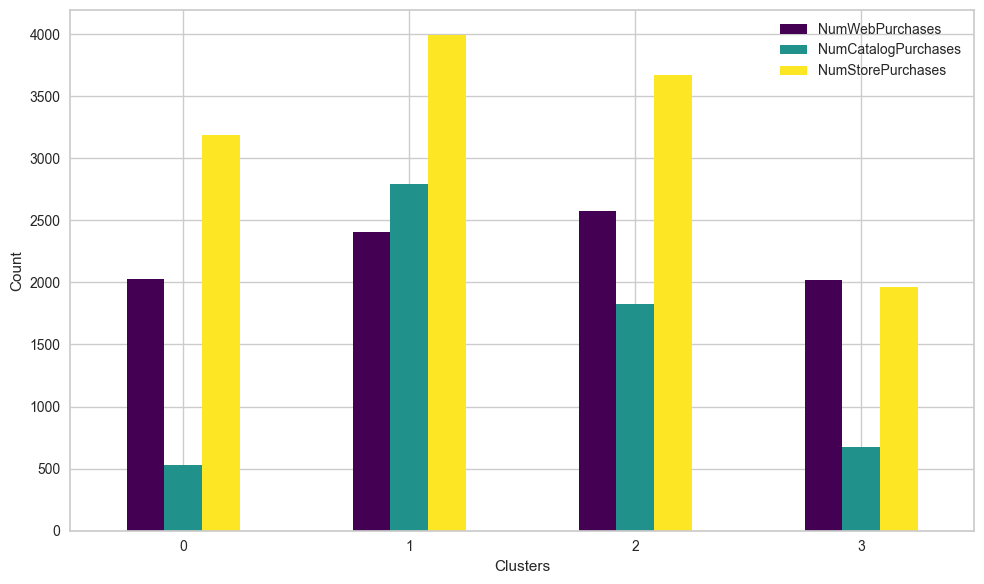

In [43]:
purchase_type = ['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']
grouped_by_purchase_type = df.groupby('Clusters')[purchase_type].sum()
barplot_grouped_data(grouped_by_purchase_type, xlabel='Clusters', ylabel='Count', title=None, cmap='viridis', rotate=False)